# Earthquake seismology with DAS-Saving each event in a .h5 file

#### Todo List:
1. Reference earthquakes by Evid rather than dataframe index
2. Make a map of all of the detected events
3. Try some xcorr

In [1]:
import h5py
import matplotlib.pyplot as plt
from scipy.signal import butter, filtfilt
import numpy as np
import datetime
import pandas as pd
from dasquakes import *
import obspy
from obspy import UTCDateTime
from obspy.clients.fdsn import Client
from libcomcat.search import search
from libcomcat.dataframes import get_summary_data_frame
import geopy.distance
from obspy.taup import TauPyModel

ERROR 1: PROJ: proj_create_from_database: Open of /home/velgueta/.conda/envs/python-obspy/share/proj failed


# Plotting the event from data set saved as g (new file.h5)


In [2]:
chan_min=0
chan_max=-1


data_file = h5py.File('/data/fast0/veronica-scratch/uw61862591.h5','r')

this_data = np.array(data_file['Acquisition/Raw[0]/RawData'][:,chan_min:chan_max])
this_time = np.array(data_file['Acquisition/Raw[0]/RawDataTime'])
            
    

#this_time2 = sintela_to_datetime(stamp)



attrs=dict(data_file['Acquisition'].attrs)

data_file.close()
    

            

In [3]:
chan_min=0
chan_max=-1


data_file1 = h5py.File('/data/fast0/veronica-scratch/uw61862591.h5','r')

this_data1 = np.array(data_file1['Acquisition/Raw[0]/RawData'][:,chan_min:chan_max])
this_time1 = np.array(data_file1['Acquisition/Raw[0]/RawDataTime'])
            
    

#this_time2 = sintela_to_datetime(stamp)



attrs1=dict(data_file1['Acquisition'].attrs)

data_file1.close()
    

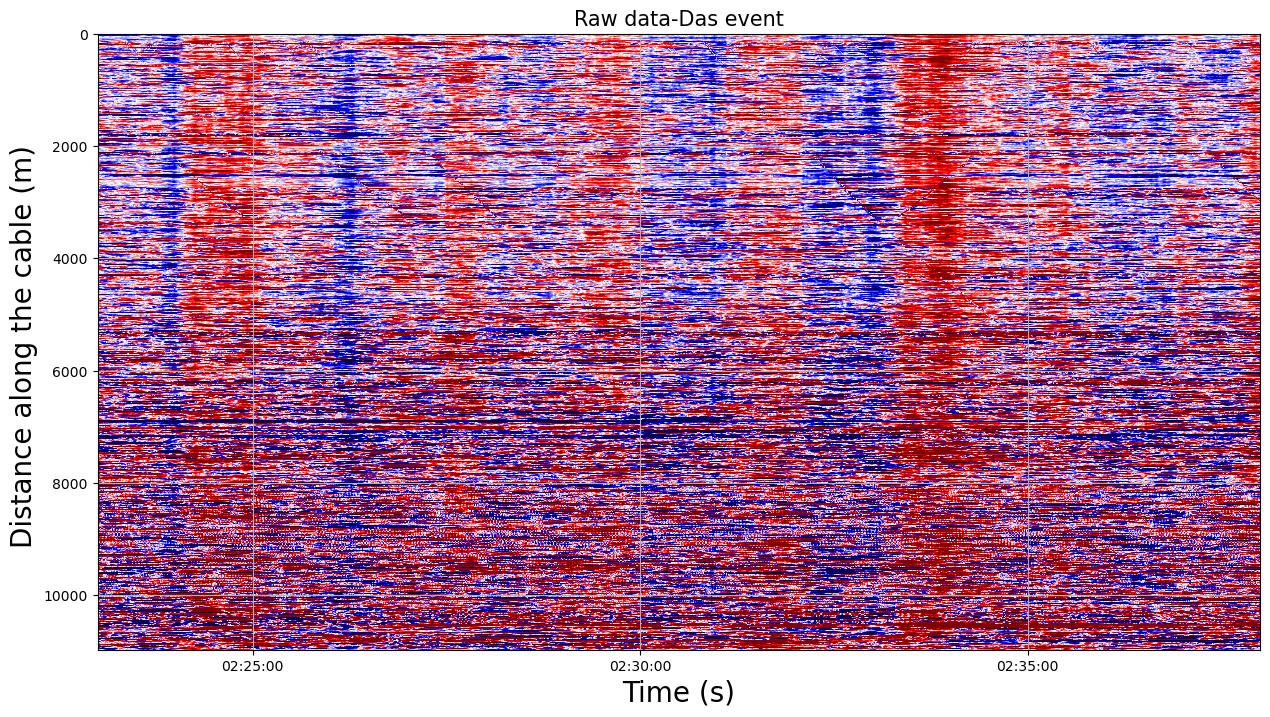

In [4]:
import matplotlib.pyplot as plt
from scipy.signal import butter, filtfilt
import matplotlib.dates as mdates

#date_format = mdates.DateFormatter('%H:%M:%S')

date_format = mdates.DateFormatter('%H:%M:%S')
x_lims1 = mdates.date2num(this_time)
x_max = this_data.shape[1] * attrs1['SpatialSamplingInterval']
fig,ax=plt.subplots(figsize=(15,8))
plt.imshow(this_data.T,cmap='seismic',aspect='auto',vmin=-1,vmax=1,extent=[x_lims1[0],x_lims1[-1],x_max,0])
plt.title('Raw data-Das event',fontsize=15)
plt.xlabel("Time (s)",fontsize=20)
plt.ylabel("Distance along the cable (m) ", fontsize=20)

ax.xaxis.set_major_formatter(date_format)
ax.xaxis_date()
plt.grid()
plt.show()

In [6]:
#low_cut1 = 3
#hi_cut1 = 8
low_cut1 = 1
hi_cut1 = 10

b,a = butter(2,(low_cut1,hi_cut1),'bp',fs=attrs1['MaximumFrequency']*2)
data_filt = filtfilt(b,a,this_data,axis=0)

data_filt1 = filtfilt(b,a,this_data1,axis=0)

# plotting the files saved

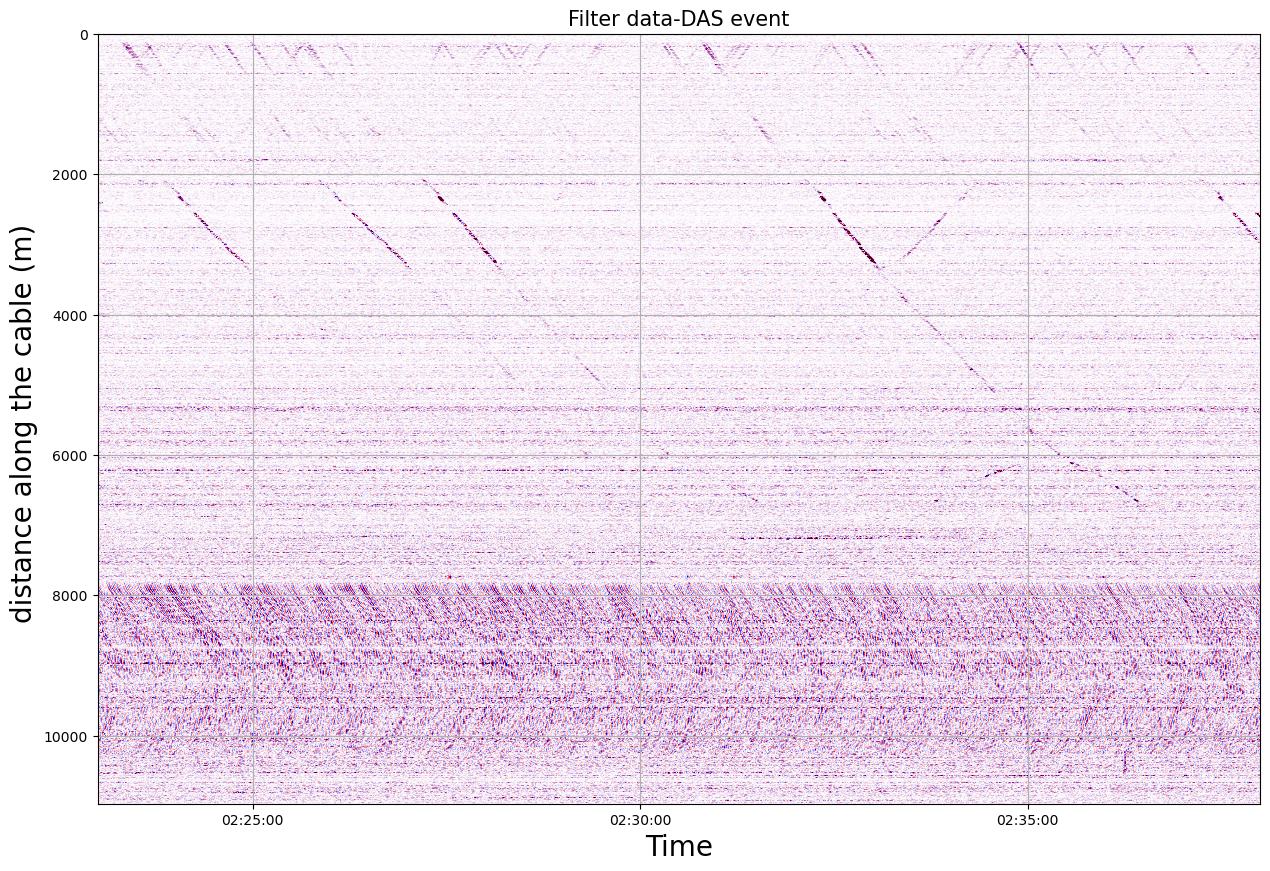

In [9]:
date_format = mdates.DateFormatter('%H:%M:%S')
x_lims = mdates.date2num(this_time)
x_max = data_filt.shape[1] * attrs['SpatialSamplingInterval']
fig,ax=plt.subplots(figsize=(15,10))
plt.imshow(data_filt.T,cmap='seismic',aspect='auto',vmin=-0.05,vmax=0.05,extent=[x_lims[0],x_lims[-1],x_max,0])
plt.title('Filter data-DAS event', fontsize=15)
plt.xlabel("Time", fontsize=20)
plt.ylabel("distance along the cable (m) ", fontsize=20)

ax.xaxis.set_major_formatter(date_format)
ax.xaxis_date()
plt.grid()
plt.show()

In [11]:
def correlate(s1,s2,mode="same"):

    # throw an error of input sizes are inconsistent
    if s1.shape != s2.shape:
        raise ValueError("s1 and s2 must have the same size!")

    # get fft size
    sz = s1.shape[0]
    n_bits = 1+int(np.log2(2*sz-1))
    fft_sz = 2**n_bits

    # take FFT along time axis for both
    fft_s1 = np.fft.fft(s1, fft_sz, axis=0)
    fft_s2 = np.fft.fft(s2, fft_sz, axis=0)

    # take complex conjugate of second signal
    fft_s2_conj = np.conj(fft_s2)

    # multiply to get correlation function
    corr_fft = fft_s1*fft_s2_conj

    # take inverse fourier transform
    corr = np.fft.ifft(corr_fft, axis=0)

    # normalize using the magnitude of both input data
    norm1 = np.linalg.norm(s1,axis=0)
    norm2 = np.linalg.norm(s2,axis=0)
    norm_factor = norm1*norm2
    corr = np.vstack((corr[-(sz-1) :], corr[:sz]))
    norm_corr = np.real(corr) / norm_factor

    # return desired part of correlation function
    if mode == "full":
        pass
    elif mode == "same":
        norm_corr = norm_corr[int(sz/2):-int(sz/2)+1]
    return norm_corr




In [12]:
corrs  = correlate(data_filt,data_filt1)


In [17]:
np.max(corrs)

1.0000000000000313

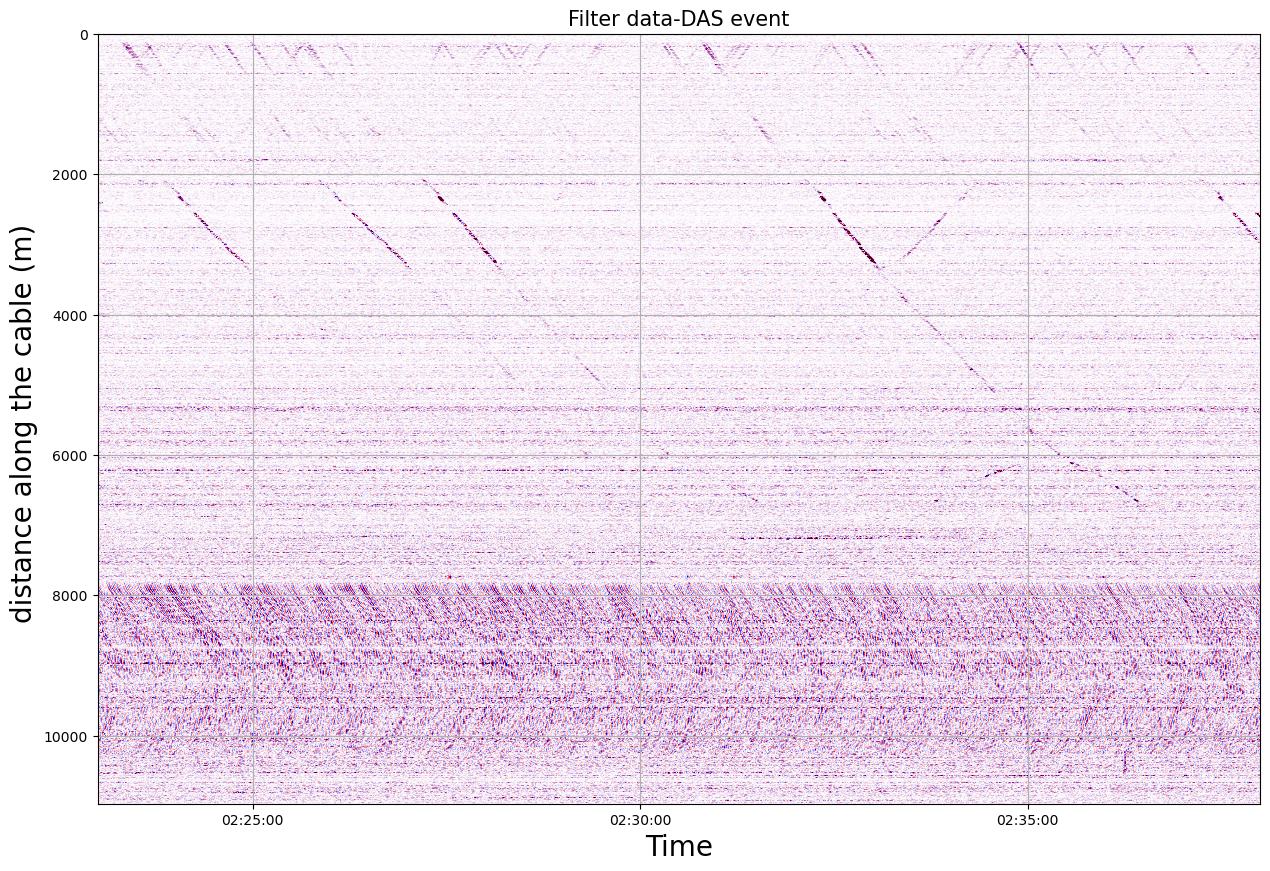

In [10]:
date_format = mdates.DateFormatter('%H:%M:%S')
x_lims1 = mdates.date2num(this_time1)
x_max1 = data_filt1.shape[1] * attrs1['SpatialSamplingInterval']
fig,ax=plt.subplots(figsize=(15,10))
plt.imshow(data_filt1.T,cmap='seismic',aspect='auto',vmin=-0.05,vmax=0.05,extent=[x_lims1[0],x_lims1[-1],x_max1,0])
plt.title('Filter data-DAS event', fontsize=15)
plt.xlabel("Time", fontsize=20)
plt.ylabel("distance along the cable (m) ", fontsize=20)

ax.xaxis.set_major_formatter(date_format)
ax.xaxis_date()
plt.grid()
plt.show()

In [ ]:
#plotting one channel or two
fig, ax = plt.subplots(figsize=(10,5))
date_format = mdates.DateFormatter('%H:%M:%S')
x_lims1 = mdates.date2num(this_time)

plt.plot(x_lims1[2000:25000],data_filt2[2000:25000,1600],label='Seafloor channel')
plt.plot(x_lims1[2000:25000],data_filt2[2000:25000,500],label='Road channel')
plt.ylabel("Phase (Radians)", fontsize=15)
plt.xlabel("Time (s)-UTC", fontsize=15)
#plt.plot(x_lims1,data_filt2[:,1100],label='another channel')

ax.xaxis.set_major_formatter(date_format)

plt.grid()
plt.legend()
plt.show()

In [ ]:
data_filt2.shape

In [ ]:
data_filt2[:,1500]

In [ ]:
this_data.shape

In [ ]:
this_time

In [ ]:
this_time.shape

In [ ]:
import matplotlib.dates as mdates
import datetime

# Crear una lista de objetos datetime
dates = [
    datetime.datetime(2022, 8, 4, 13, 22, 0),
    datetime.datetime(2022, 8, 4, 13, 23, 0),
    datetime.datetime(2022, 8, 4, 13, 24, 0)
]

# Convertir los objetos datetime en números flotantes utilizando mdates.date2num
date_numbers = mdates.date2num(dates)

print(date_numbers)


In [ ]:
dates.shape

In [ ]:
this_time[11000]